In [1]:
# install pyreadstat
!pip install pyreadstat

In [1]:
#import necessary libraries
import pyreadstat
import pandas as pd
import numpy as np

In [2]:
# load the data
df, meta = pyreadstat.read_sav("afro2016.sav", encoding="latin1")


In [3]:
#print first few rows
df.head()

,RESPNO,COUNTRY,COUNTRY_R5List,COUNTRY.BY.REGION,URBRUR,REGION,LOCATION.LEVEL.1,EA_SVC_A,EA_SVC_B,EA_SVC_C,...,R1.only,R2.only,R3.only,R4.only,R5.only,West.Africa.only,East.Africa.only,Southern.Africa.only,North.Africa.only,Central.Africa.only
0,ALG0001,1.0,1.0,4.0,2.0,1424.0,Jelfa,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,ALG0002,1.0,1.0,4.0,2.0,1424.0,Jelfa,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,ALG0003,1.0,1.0,4.0,2.0,1424.0,Jelfa,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,ALG0004,1.0,1.0,4.0,2.0,1424.0,Jelfa,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,ALG0005,1.0,1.0,4.0,2.0,1424.0,Jelfa,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# retrieve metadata
colnames = meta.column_names
collabels = meta.column_labels

In [5]:
# make a table containing the column name and corresponding column labels
varList = {'col_names': colnames, 'col_labels': collabels}
varList = pd.DataFrame(varList)

In [6]:
# uncomment to see the list of variables and their labels
#varList

In [7]:
#find labels that contain the keyword "bribe"
varList[varList["col_labels"].str.contains("bribe")]

,col_names,col_labels
148,Q48D,Q48d. Elections: voters are bribed
181,Q55B,Q55b. Pay bribe for school services
183,Q55D,Q55d. Pay bribe for treatment at public clinic...
185,Q55F,Q55f. Pay bribe for document or permit
187,Q55H,Q55h. Pay bribe for household services
189,Q55J,Q55j. Pay bribe to avoid problem with police
191,Q55L,Q55l. Pay bribe to get assistance from courts
192,Q56,Q56. Reported payment of bribes to government


In [90]:
df["Q55H"].unique()

array([ 0.,  7.,  3.,  1., -1.,  2.,  9.])

In [11]:
#: 0=Never, 1=Once or twice, 2=A few times, 3=Often, 7= No contact (DNR), 9=Don’t know,98=Refused to answer, -1=Missing

def bribe_dummy(value):
    '''
    Cleans bribery questions
    
    Args: 
    value (column) - name of the variable
    
    Returns:
    Cleaned dummy values
    '''
    if value == 0:
        return 0
    elif value == 1:
        return 1
    elif value == 2:
        return 1
    elif value ==3:
        return 1
    elif value == 7:
        return np.nan
    elif value == 9:
        return 0
    elif value == 98:
        return 0
    elif value == -1:
        return np.nan
    elif isinstance(value, float) and math.isnan(value):
        return np.nan

*List of questions to measure corruption incidence*  
- Q55h. Pay bribe for water or sanitation services
- Q55b. Pay bribe for public school services 
- Q55d. Pay bribe for treatment at public clinic or hospital
- Q55F Pay bribe for document or permit
- Q55j. Pay bribe to avoid problem with police
- Q55l. Pay bribe to get assistance from courts

In [10]:
# clean the bribery questions by using dummy generator above     
df["water_bribe"] = df["Q55H"].apply(bribe_dummy)
df["school_bribe"] = df["Q55B"].apply(bribe_dummy)
df["medicine_bribe"] = df["Q55D"].apply(bribe_dummy)
df["permit_bribe"] = df["Q55F"].apply(bribe_dummy)
df["police_bribe"] = df["Q55J"].apply(bribe_dummy)
df["court_bribe"] = df["Q55L"].apply(bribe_dummy)

In [13]:
# uncomment to see tabulations per country
#df.groupby("COUNTRY")["water_bribe"].value_counts()

In [14]:
# function to make dummy variables
def make_table(df, countries_col, col):
    '''
    Args: 
    df - dataframe
    countries_col - column containing country names
    col - column on the incidence of corruption in a sector
    
    Return: dataset containing corruption incidence for the chosen sector for all countries
    '''
    # make a table with chosen columns
    table = df[[countries_col, col]]
    # create dummy variables from the corruption column
    dummies = pd.get_dummies(table[col])
    #concatenate the dummies to the main table
    dummy_table = pd.concat([table, dummies], axis = 1)
    # drop rows containing NAs
    dummy_table.dropna(inplace = True, axis = 0)
    #calculate corruption incidence by dividing the sum of positives by the size of the group rows
    final = pd.DataFrame(dummy_table.groupby("COUNTRY")[1.0].sum()/dummy_table.groupby("COUNTRY")[1.0].size()*100)
    return final   
    

In [15]:
# Make bribery incidence tables per sector
water = make_table(df, "COUNTRY", "water_bribe")
edu = make_table(df, "COUNTRY", "school_bribe")
med = make_table(df, "COUNTRY", "medicine_bribe")
official = make_table(df, "COUNTRY", "permit_bribe")
pol = make_table(df, "COUNTRY", "police_bribe")
judge = make_table(df, "COUNTRY", "court_bribe")



In [18]:
# Concatenate all the bribery tables created in the previous stage
incidence_table = pd.concat([water, edu, med, official, pol, judge], axis = 1)
incidence_table.columns = ["Bribery in W&S", "Bribery in schools", "Bribery in health services", "Bribery to obtain permits", 
                           "Bribery in police", "Bribery in courts"]
incidence_table

,Bribery in W&S,Bribery in schools,Bribery in health services,Bribery to obtain permits,Bribery in police,Bribery in courts
COUNTRY,,,,,,
1.0,6.358382,7.092199,6.469298,7.666667,8.000000,9.292035
2.0,20.812183,8.362369,12.573099,26.871401,19.548872,20.930233
3.0,0.000000,0.604839,0.000000,0.256410,1.104972,0.000000
4.0,4.347826,9.751037,3.532609,8.639309,7.142857,7.692308
5.0,7.462687,12.113402,2.366127,11.083123,27.819549,22.292994
6.0,32.911392,30.483871,29.868421,34.354839,34.705882,32.444444
7.0,1.190476,2.035623,1.187335,0.886918,0.000000,1.600000
8.0,14.130435,17.249417,18.115942,29.094828,25.000000,25.925926
9.0,44.306418,25.636672,32.138728,46.117274,45.060241,53.353659


In [19]:
# Creat a dictionary with country names
names = {1: "Algeria", 2: "Benin", 3: "Botswana", 4: "Burkina Faso", 5: "Burundi", 6: "Cameroon", 7: "Cape Verde", 8: "Cote d'Ivoire", 
         9: "Egypt", 10: "Gabon", 11: "Ghana", 12: "Guinea", 13: "Kenya", 14: "Lesotho", 15: "Liberia", 16: "Madagascar", 
         17: "Malawi", 18: "Mali", 19: "Mauritius", 20: "Morocco", 21: "Mozambique", 22: "Namibia", 23: "Niger", 
         24: "Nigeria", 25: "São Tomé and Príncipe", 26: "Senegal", 27: "Sierra Leone", 28: "South Africa", 29: "Sudan", 
         30: "Swaziland", 31: "Tanzania", 32: "Togo", 33: "Tunisia", 34: "Uganda", 35: "Zambia", 36: "Zimbabwe"}
incidence_table.reset_index(level=0, inplace=True)
incidence_table.columns


Index(['COUNTRY', 'Bribery in W&S', 'Bribery in schools',
       'Bribery in health services', 'Bribery to obtain permits',
       'Bribery in police', 'Bribery in courts'],
      dtype='object')

In [20]:
# Convert the country column to integer first
pd.to_numeric(incidence_table["COUNTRY"], downcast='integer')


0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
Name: COUNTRY, dtype: int8

In [21]:
#Insert countr names using the above dictionary
incidence_table.replace({"COUNTRY": names}, inplace = True)

In [22]:
incidence_table.head()

,COUNTRY,Bribery in W&S,Bribery in schools,Bribery in health services,Bribery to obtain permits,Bribery in police,Bribery in courts
0,Algeria,6.358382,7.092199,6.469298,7.666667,8.000000,9.292035
1,Benin,20.812183,8.362369,12.573099,26.871401,19.548872,20.930233
2,Botswana,0.000000,0.604839,0.000000,0.256410,1.104972,0.000000
3,Burkina Faso,4.347826,9.751037,3.532609,8.639309,7.142857,7.692308
4,Burundi,7.462687,12.113402,2.366127,11.083123,27.819549,22.292994


## Calculations 
The following calculations answer a number of questions using the cleaned data.

In [25]:
#is water the most corrupt sector?
row_max = incidence_table.max(axis=1)
check = incidence_table["Bribery in W&S"] == row_max
check.value_counts()


False    34
True      2
dtype: int64

In [26]:
#is water the least corrupt sector?
row_min = incidence_table.min(axis=1)
check = incidence_table["Bribery in W&S"] == row_min
check.value_counts()


False    30
True      6
dtype: int64

In [27]:
# is water corruption higher than (or equal to) the average of all others?
row_mean = incidence_table.mean(axis=1)
check = incidence_table["Bribery in W&S"] >= row_mean
check.value_counts()

False    22
True     14
dtype: int64

In [28]:
# is water corruption higher than (or equal to) the average of all others? EXCLUDING water
row_mean_nowater = incidence_table.drop(["Bribery in W&S"], axis=1).mean(axis=1)
check = incidence_table["Bribery in W&S"] >= row_mean_nowater
check.value_counts()

False    22
True     14
dtype: int64

In [29]:
# is water corruption higher than (or equal to) the medium of all others?
row_median = incidence_table.median(axis=1)
check = incidence_table["Bribery in W&S"] >= row_median
check.value_counts()


False    22
True     14
dtype: int64

## Results
Bribery incidence in the W&S section is the highest in 2 countries, and lowest in 6 countries. Bribery incidence in the W&S section is higher than the average of all other studied public services in 14 countries, out of 36.

In [30]:
# Create ranking of the sectors per country based on the bribery incidence rate in W&S
incidence_table.sort_values("Bribery in W&S", ascending = False).round(2)

,COUNTRY,Bribery in W&S,Bribery in schools,Bribery in health services,Bribery to obtain permits,Bribery in police,Bribery in courts
14,Liberia,56.39,45.20,52.42,59.68,60.73,52.85
8,Egypt,44.31,25.64,32.14,46.12,45.06,53.35
9,Gabon,42.42,26.85,20.44,21.88,24.35,15.45
26,Sierra Leone,39.67,19.30,24.96,33.81,64.75,62.04
20,Mozambique,38.44,24.86,22.32,26.95,39.64,40.84
23,Nigeria,35.36,25.31,24.06,32.24,45.56,40.75
10,Ghana,34.85,24.48,17.18,37.53,57.09,36.45
5,Cameroon,32.91,30.48,29.87,34.35,34.71,32.44
19,Morocco,27.82,12.62,38.06,32.42,38.65,50.00
11,Guinea,25.93,23.94,24.88,33.80,36.11,42.86


In [32]:
# how is corruption incidence correlated across sectors?
corr.round(2)

,Bribery in W&S,Bribery in schools,Bribery in health services,Bribery to obtain permits,Bribery in police,Bribery in courts
Bribery in W&S,1.00,0.90,0.88,0.86,0.82,0.82
Bribery in schools,0.90,1.00,0.87,0.82,0.77,0.76
Bribery in health services,0.88,0.87,1.00,0.84,0.77,0.85
Bribery to obtain permits,0.86,0.82,0.84,1.00,0.84,0.84
Bribery in police,0.82,0.77,0.77,0.84,1.00,0.94
Bribery in courts,0.82,0.76,0.85,0.84,0.94,1.00


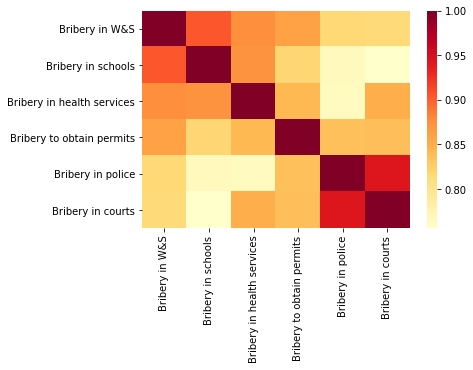

In [33]:
# how is corruption incidence correlated across sectors?
import matplotlib.pyplot as plt
import seaborn as sns

corr = incidence_table[1:].corr()

heatmap = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
                     cmap="YlOrRd")
plt.show()

In [45]:
rankings = incidence_table.rank(axis = 1, ascending=False)
rankings = pd.concat([incidence_table.COUNTRY, rankings], axis = 1)

In [47]:
# What's the distribution of ranking of W&S corruption incidence?
#Transpose the row and squeeze to obtain Pandas series, which allow value counts
rankings["Bribery in W&S"].value_counts()

4.0    9
3.0    9
5.0    8
6.0    5
2.0    3
1.0    2
Name: Bribery in W&S, dtype: int64

In [50]:
# List of countries where W&S sector corruption is ranked 1 or 2
topranks = rankings.loc[(rankings["Bribery in W&S"] == 1) | (rankings["Bribery in W&S"] == 2)]
topranks

,COUNTRY,Bribery in W&S,Bribery in schools,Bribery in health services,Bribery to obtain permits,Bribery in police,Bribery in courts
9,Gabon,1.0,2.0,5.0,4.0,3.0,6.0
13,Lesotho,1.0,6.0,4.0,2.0,5.0,3.0
18,Mauritius,2.0,6.0,5.0,4.0,1.0,3.0
25,Senegal,2.0,6.0,5.0,1.0,3.0,4.0
27,South Africa,2.0,5.0,6.0,1.0,4.0,3.0


In [51]:
# Make a list of the 5 countries where W&S corruption ranks 1 or 2
top_countries = list(topranks["COUNTRY"])
top_countries

['Gabon', 'Lesotho', 'Mauritius', 'Senegal', 'South Africa']

In [52]:
to_graph = incidence_table[incidence_table["COUNTRY"].isin(top_countries)]

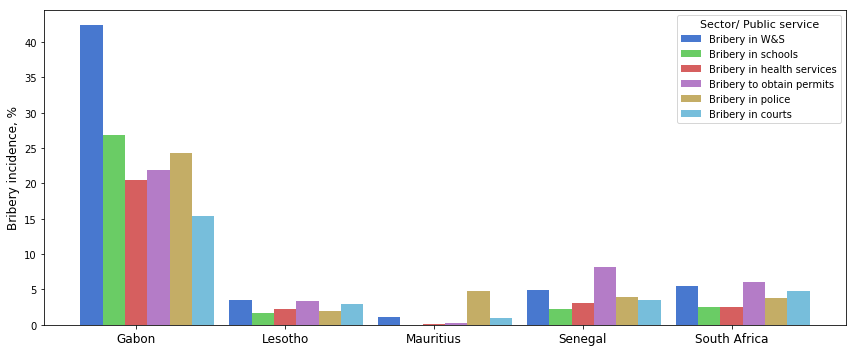

In [56]:
# graph the corruption incidence rates in ['Gabon', 'Lesotho', 'Mauritius', 'Senegal', 'South Africa']
# sectors: ["Bribery in W&S", "Bribery in schools", "Bribery in health services", "Bribery to obtain permits", 
# "Bribery in police", "Bribery in courts"]
from matplotlib import pyplot as plt
plt.style.use('seaborn-muted')

from matplotlib.pyplot import figure
figure(figsize=(12,5))

labels = list(to_graph["COUNTRY"])

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

plt.bar(x - 2*width, np.array(to_graph["Bribery in W&S"]), width, label="Bribery in W&S")
plt.bar(x - width, np.array(to_graph["Bribery in schools"]), width, label="Bribery in schools")
plt.bar(x , np.array(to_graph["Bribery in health services"]), width, label="Bribery in health services")
plt.bar(x + width, np.array(to_graph["Bribery to obtain permits"]), width, label="Bribery to obtain permits")
plt.bar(x + 2* width, np.array(to_graph["Bribery in police"]), width, label="Bribery in police")
plt.bar(x + 3* width, np.array(to_graph["Bribery in courts"]), width, label="Bribery in courts")

plt.xticks(ticks = x, labels = labels, fontsize=12)
plt.ylabel("Bribery incidence, %", fontsize=12)
plt.legend(loc='upper right', fontsize=10, title = "Sector/ Public service", title_fontsize = 11)

plt.tight_layout()

plt.show()

In [57]:
# five countries that have the highest bribery incidence in W&S
top5 = incidence_table.sort_values("Bribery in W&S", ascending = False).round(2).head()

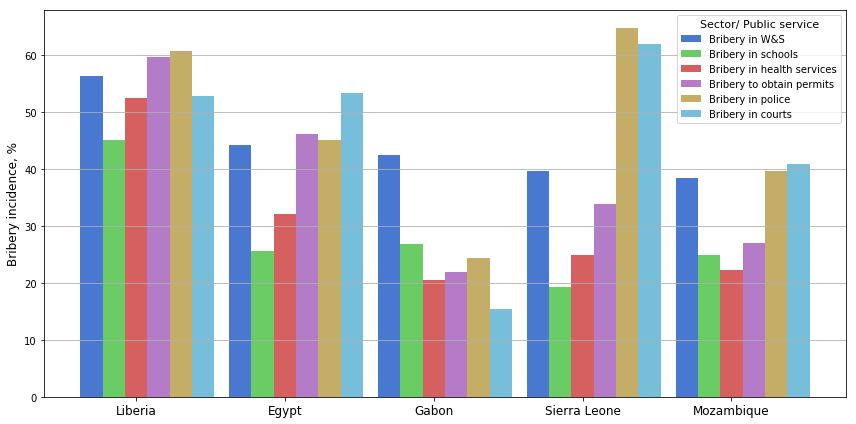

In [63]:
figure(figsize=(12,6))

labels = list(top5["COUNTRY"])

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

plt.bar(x - 2*width, np.array(top5["Bribery in W&S"]), width, label="Bribery in W&S")
plt.bar(x - width, np.array(top5["Bribery in schools"]), width, label="Bribery in schools")
plt.bar(x , np.array(top5["Bribery in health services"]), width, label="Bribery in health services")
plt.bar(x + width, np.array(top5["Bribery to obtain permits"]), width, label="Bribery to obtain permits")
plt.bar(x + 2* width, np.array(top5["Bribery in police"]), width, label="Bribery in police")
plt.bar(x + 3* width, np.array(top5["Bribery in courts"]), width, label="Bribery in courts")

plt.grid(axis='y')
plt.xticks(ticks = x, labels = labels, fontsize=12)
plt.ylabel("Bribery incidence, %", fontsize=12)
plt.legend(loc='upper right', fontsize=10, title = "Sector/ Public service", title_fontsize = 11)

plt.tight_layout()

plt.show()

In [62]:
# How many times is the bribery incidence in W&S higher compared to the least corrupt sector in each country

times = incidence_table.sort_values("Bribery in W&S", ascending = False).round(2)
times["min"] = times.min(axis=1)

# new column divides the water corruption rate by the minimum
times["times_larger"] = times["Bribery in W&S"]/times["min"]
times.sort_values("times_larger", ascending = False)

,COUNTRY,Bribery in W&S,Bribery in schools,Bribery in health services,Bribery to obtain permits,Bribery in police,Bribery in courts,min,times_larger
18,Mauritius,1.16,0.00,0.11,0.31,4.85,1.02,0.00,inf
6,Cape Verde,1.19,2.04,1.19,0.89,0.00,1.60,0.00,inf
21,Namibia,2.89,3.43,2.21,4.77,2.77,0.91,0.91,3.175824
4,Burundi,7.46,12.11,2.37,11.08,27.82,22.29,2.37,3.147679
16,Malawi,9.69,10.68,5.67,3.35,27.12,20.17,3.35,2.892537
9,Gabon,42.42,26.85,20.44,21.88,24.35,15.45,15.45,2.745631
1,Benin,20.81,8.36,12.57,26.87,19.55,20.93,8.36,2.489234
12,Kenya,20.13,8.91,11.64,39.44,49.93,40.35,8.91,2.259259
19,Morocco,27.82,12.62,38.06,32.42,38.65,50.00,12.62,2.204437
27,South Africa,5.46,2.58,2.52,6.06,3.83,4.80,2.52,2.166667


### The last table shows that, in every 3rd country, the bribery incidence rate in the W&S sector is at least two times higher than the least corrupt public service sector in the country